# Problem Statement

Our client wants to try to predict COVID-19 hotspots based on demographics and has asked us to build a predictive model that could predict if a county is a COVID-19 hotspot.  Since we are cautious about trying to predict an ongoing problem with many changes in real-time data, we informed that if our models don't meet a __.95 accuracy score or better__ that they should only use the model for interpretive purposes and not predictive purposes.  While the client understands the low likelihood of building a predictive model under this criteria, they gave us the budget to proceed anyway.

We defined a "COVID-19 hotspot" as a county in the contiguous US that has a rate of infected residents per capita that is higher than one standard deviation for the mean.  This actually presents an interesting situation where we already know that our baseline model will have an accuracy rate of .7625.  Due to this, we will only consider our model interpretable if we can beat the baseline accuracy.

We are viewing this as a classification problem and will look to run Logistic Regression, KNN, Support Vector Machine, Decision Tree Classifier, Bagging Classifier,Random Forest, and AdaBoost models in order to see if it's possible to predict COVID-19 hotspots based on county demographic data.

To reiterate, our goal for the model to be considered predictive is a __.95 accuracy score or better__, and our goal for the model to be considered interpretable is a __.7626 accuracy score or better__.  This is to ensure that we are held to high standards when it comes to predicting an ongoing pandemic, but also ensures that we can interpret the findings if we are performing better than average.



# Executive Summary

# Data Collection

In [2179]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.base import TransformerMixin # from Mahdi

import regex as re

random_state = 11

##### Data was pulled on May 8.

In [2180]:
master = pd.read_csv('~/downloads/new_beds.csv')

In [2181]:
master = master.drop(columns = 'Unnamed: 0')

Master was the result of all of our cleaned dataframes merged into one, however we found some more specific area data after the fact, which is why we read in a separate dataframe.  We will have to do a little more cleaning, but master will remain as our Master dataframe.

In [2182]:
area = pd.read_csv('~/downloads/area_ready.csv')


In [2183]:
area = area.drop(columns = 'Unnamed: 0')
# csv was created without index = False, so have to drop the first column
area.head()

,county,total_area,land_area,water_area
0,autauga county,1513895194,1539602155,2.570696e+07
1,baldwin county,2984648805,4117625664,1.132977e+09
2,barbour county,2241636927,2292160140,5.052321e+07
3,bibb county,1602558222,1612159622,9.601400e+06
4,blount county,1655136409,1670127873,1.499146e+07


# Additional Cleaning

Since we are still treated our master as the master, first, we're going to merge area and master and save over the master dataframe.

In [2184]:
master = pd.merge(area, master, how = 'left', on=area.index)

master.head()

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,0,autauga county,1513895194,1539602155,2.570696e+07,autauga county,AL,1001,55200,54170,...,0.0,0.0,0.0,0.0,1,1001,85.0,0.001214,0.001540,1.268657
1,1,baldwin county,2984648805,4117625664,1.132977e+09,baldwin county,AL,1003,208107,204535,...,0.0,0.0,0.0,0.0,1,1003,386.0,0.000999,0.001855,1.855769
2,2,barbour county,2241636927,2292160140,5.052321e+07,barbour county,AL,1005,25782,25429,...,0.0,0.0,0.0,0.0,1,1005,74.0,0.002056,0.002870,1.396226
3,3,bibb county,1602558222,1612159622,9.601400e+06,bibb county,AL,1007,22527,22340,...,0.0,0.0,0.0,0.0,1,1007,35.0,0.001953,0.001554,0.795455
4,4,blount county,1655136409,1670127873,1.499146e+07,blount county,AL,1009,57645,56710,...,0.0,0.0,0.0,0.0,1,1009,25.0,0.000763,0.000434,0.568182


Even though we've cleaned, we still want to check our null values.

In [2185]:
master.isnull().sum().sort_values()

key_0                                  0
# hosp w/diag radioisotope fac         0
other spec, tot, pc, hosp res          0
forensic path, pc, hosp ft stf         0
# stng/lt hosps,100-199 beds_y         0
                                    ... 
skilled nurs fac certified beds_x      0
# stng/lt hosps,050-099 beds_x         0
nursing home beds, st gen hosp_x       0
water_area                             1
beds_per_case                        103
Length: 853, dtype: int64

We are going to end up dropping beds per case when we set up our X & y variables because that would be technically leaking coronavirus data into our model, but for EDA purposes, it could be worth keeping around.  I'm more concerned investigating the water area null.

In [2186]:
master.loc[master['water_area'].isnull()]

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
889,889,greeley county,2016057907,2016057907,NaN,greeley county,KS,20071,1200,1179,...,0.0,0.0,0.0,0.0,20,20071,18.0,0.0,0.015,inf


In [2189]:
master.sort_values(by = 'case_per_pop', ascending = False)

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
2478,2478,trousdale county,290182875,296143584,5960709.0,trousdale county,TN,47169,9573,9105,...,0.0,0.0,0.0,0.0,47,47169,25.0,0.141544,0.002612,0.018450
106,106,lincoln county,1426848085,1454363491,27515406.0,lincoln county,AR,5079,13695,13622,...,0.0,0.0,0.0,0.0,5,5079,0.0,0.066229,0.000000,0.000000
1794,1794,dakota county,1327294423,1354269882,26975459.0,dakota county,NE,31043,20317,19820,...,0.0,0.0,0.0,0.0,31,31043,0.0,0.065118,0.000000,0.000000
1332,1332,nobles county,1832764854,1852080823,19315969.0,nobles county,MN,27105,21839,21450,...,0.0,0.0,0.0,0.0,27,27105,48.0,0.053894,0.002198,0.040782
2397,2397,bledsoe county,1051815457,1052644801,829344.0,bledsoe county,TN,47007,14602,14198,...,0.0,0.0,0.0,0.0,47,47007,25.0,0.041364,0.001712,0.041391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2701,2701,somervell county,468738044,482948955,14210911.0,somervell county,TX,48425,8743,8684,...,0.0,0.0,0.0,0.0,48,48425,16.0,0.000000,0.001830,inf
181,181,modoc county,9565374364,10225877677,660503313.0,modoc county,CA,6049,8938,8691,...,0.0,0.0,0.0,0.0,6,6049,20.0,0.000000,0.002238,inf
2695,2695,schleicher county,3394458666,3394546067,87401.0,schleicher county,TX,48413,3061,3060,...,0.0,0.0,0.0,0.0,48,48413,14.0,0.000000,0.004574,inf
2694,2694,san saba county,2932146951,2940447162,8300211.0,san saba county,TX,48411,5962,5695,...,0.0,0.0,0.0,0.0,48,48411,0.0,0.000000,0.000000,NaN


Since total area for Greeley County equals land area, I'm going to impute 0 for water area in this case.

In [2152]:
master['water_area'].replace({None: 0}, inplace = True)

master['pop_density'] = master['population'] / master['total_area']

The census data we collected is in total units, but we want to see if ratios might be a better predictor of hotspots than a total.  We do want to be able to feed both into our model.  To get started, we feature engineered a column for population density.  Next we want to create a for loop to loop through the all data columns and create ratios with the population as a denominator for all of them.

In [2153]:
cens = master[master.columns[8:]]
cens.drop(columns = 'county_y', inplace = True) #ran code to find this as the only object column
cens.shape

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(3108, 845)

We obviously have a lot of columns, which will possibly lead to some overfit models.  We can address this in the modeling section.

In [2154]:
ratios = [] # instantiate empty list
for num in range(845): #iterates through all census columns
    ratio = cens[cens.columns[num]]/ cens['population']
    ratios.append(ratio) 
    

ratio_df = pd.DataFrame(ratios).T 
#turn list into a dataframe, need to transpose, so the values and columns line up properly
ratio_df.columns =  cens.columns

ratio_df.columns = ratio_df.columns + ' ratio'

ratio_df.head()

,population ratio,estimate!!race!!total population!!one race ratio,estimate!!race!!total population!!two or more races ratio,estimate!!race!!total population!!one race.1 ratio,estimate!!race!!total population!!one race!!white ratio,estimate!!race!!total population!!one race!!black or african american ratio,estimate!!race!!total population!!one race!!american indian and alaska native ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!cherokee tribal grouping ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!chippewa tribal grouping ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!navajo tribal grouping ratio,...,nursing facilities total beds ratio,nurse practitioners_y ratio,"advpractnurs midwve,male w/npi ratio",st_num ratio,countyfips ratio,beds ratio,case_per_pop ratio,beds_per_pop ratio,beds_per_case ratio,pop_density ratio
0,1.0,0.981341,0.018659,0.981341,0.768786,0.191395,0.002880,0.001486,0.0,0.000797,...,0.0,0.0,0.0,0.000018,0.018134,0.001540,2.198855e-08,2.789593e-08,0.000023,6.605477e-10
1,1.0,0.982836,0.017164,0.982836,0.862662,0.094970,0.007314,0.001369,0.0,0.000336,...,0.0,0.0,0.0,0.000005,0.004820,0.001855,4.802750e-09,8.912795e-09,0.000009,3.350478e-10
2,1.0,0.986308,0.013692,0.986308,0.473819,0.475758,0.002793,0.001008,0.0,0.000349,...,0.0,0.0,0.0,0.000039,0.038981,0.002870,7.973384e-08,1.113265e-07,0.000054,4.461026e-10
3,1.0,0.991699,0.008301,0.991699,0.766547,0.222755,0.000355,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000044,0.044702,0.001554,8.670536e-08,6.897017e-08,0.000035,6.240023e-10
4,1.0,0.983780,0.016220,0.983780,0.955052,0.014954,0.002446,0.000347,0.0,0.000000,...,0.0,0.0,0.0,0.000017,0.017504,0.000434,1.324126e-08,7.523445e-09,0.000010,6.041798e-10


In [2155]:
# ratio_df.to_csv('~/documents/population_ratios.csv')

In [2156]:
master = master.join(ratio_df)

We overwrote the Master to include the ratio columns.  Data is cleaned up to where we want.

# EDA

The first thing we want to see is what the distribution of our likely target (Cases per Capita).

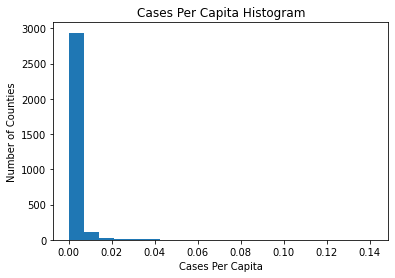

In [2157]:
plt.hist(master['case_per_pop'], bins = 20)
plt.title('Cases Per Capita Histogram')
plt.xlabel('Cases Per Capita')
plt.ylabel('Number of Counties');

The target variable has a distribution that is right-skewed, which makes sense since you can't have a negative number with this feature.  Taking the log did not even out the distribution.

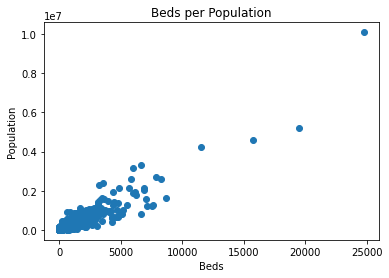

In [2158]:
plt.scatter(master['beds'], master['population'])
plt.title('Beds per Population')
plt.xlabel('Beds')
plt.ylabel('Population');

We also wanted to look for any discrepancies in the amount of hospital beds given the population of a county, but found that the relationship is fairly linear with a positive correlation.  This is not surprising because one would typically expect that areas with higher populations are more likely to have a greater number of hospital beds.

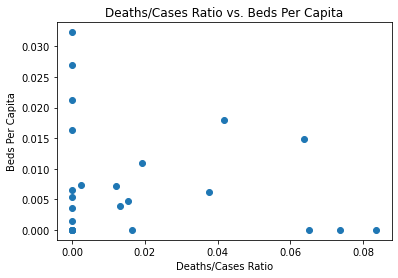

In [2159]:
plt.scatter(master['deaths']/master['cases'], master['beds_per_pop'])
plt.title('Deaths/Cases Ratio vs. Beds Per Capita')
plt.xlabel('Deaths/Cases Ratio')
plt.ylabel('Beds Per Capita');


This finding was fascinating.  We wanted to explore the relationship between the likelihood of COVID-19 resulting in death compared to the amount of hospital beds per capita.  We do have many counties that have cases, but not any deaths, so that does technically throw off some of the linearity at this point in time. However, we do appear to see a slight negative correlation in this graph, which suggests that COVID-19 cases are more likely to become severe in counties that don't have a lot of hospital beds relative to their population. 

In [2160]:
.95/2/2

0.2375

In [2161]:
master.shape[0] * 0.2375

738.15

In [2162]:
master.shape[0] - 739

2369

This informs us on how many counties will be designated as a "hotspot," as determined by counties that fall one standard deviation above the mean in terms of infections per capita.  I'm going to round up for the cutoff because the value should be larger than 738, and since you can't have .15 of a county, I will use 739 as designated hotspots.  That leaves us with 2369 that will not be considered hotspots.

In [2163]:
above_std_1 = master.sort_values(by = 'case_per_pop', ascending = False).head(739)

This creates a list of counties that meet our criteria of a COVID-19 hotspot.

In [2164]:
above_std_1['case_per_pop'].sort_values().head(1)

2    0.002056
Name: case_per_pop, dtype: float64

This shows our cutoff point for our cases per capita ratio.

In [2165]:
below = master.sort_values(by = 'case_per_pop', ascending = False).tail(2369)

In [2166]:
above_std_1['case_per_pop'] = ((above_std_1['case_per_pop'].values *0) +1).astype(int)
# converts the hotspots to a value of one for the purposes of classification
below['case_per_pop'] = ((below['case_per_pop'].values *0)).astype(int)
# converts the rest to a value of zero for the purposes of classification
master['case_per_pop'] = pd.concat([above_std_1['case_per_pop'],below['case_per_pop']])
# overwrites our cases per capita column in the master with our classifications 
master.head()

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,nursing facilities total beds ratio,nurse practitioners_y ratio,"advpractnurs midwve,male w/npi ratio",st_num ratio,countyfips ratio,beds ratio,case_per_pop ratio,beds_per_pop ratio,beds_per_case ratio,pop_density ratio
0,0,autauga county,1513895194,1539602155,2.570696e+07,autauga county,AL,1001,55200,54170,...,0.0,0.0,0.0,0.000018,0.018134,0.001540,2.198855e-08,2.789593e-08,0.000023,6.605477e-10
1,1,baldwin county,2984648805,4117625664,1.132977e+09,baldwin county,AL,1003,208107,204535,...,0.0,0.0,0.0,0.000005,0.004820,0.001855,4.802750e-09,8.912795e-09,0.000009,3.350478e-10
2,2,barbour county,2241636927,2292160140,5.052321e+07,barbour county,AL,1005,25782,25429,...,0.0,0.0,0.0,0.000039,0.038981,0.002870,7.973384e-08,1.113265e-07,0.000054,4.461026e-10
3,3,bibb county,1602558222,1612159622,9.601400e+06,bibb county,AL,1007,22527,22340,...,0.0,0.0,0.0,0.000044,0.044702,0.001554,8.670536e-08,6.897017e-08,0.000035,6.240023e-10
4,4,blount county,1655136409,1670127873,1.499146e+07,blount county,AL,1009,57645,56710,...,0.0,0.0,0.0,0.000017,0.017504,0.000434,1.324126e-08,7.523445e-09,0.000010,6.041798e-10


In [2167]:
# master.to_csv('~/documents/case_per_pop_dummied_std_1.csv')

# Model Preparation

In [2168]:
master['case_per_pop'].value_counts(normalize = True)

0    0.762227
1    0.237773
Name: case_per_pop, dtype: float64

Since we are using accuracy as our metric, our baseline is a score of .76227, which would occur if our model predicted an area to not be a coronavirus hotspot.  Since once standard deviation above the mean resulted in a decimal, we technically have a slightly lower baseline than initially thought.

In [2169]:
X = master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 
                           'case_per_pop', 'beds_per_case', 'beds_per_case ratio', 'unnamed: 0_y', 'st_num',
                           'cases', 'countyfips', 'key_0', 'county', 'case_per_pop ratio',
                           'population ratio', 'st_num ratio', 'cases ratio', 'total_covid ratio',
                           'deaths ratio', 'countyfips ratio'])
'''drops features that could leak in regards to COVID-19 data, numerical columns relating to id,
non-numerical columns, and remaining null columns'''
y = master['case_per_pop']
# sets target variable as cases per capita.

ss = StandardScaler()

X_ss = ss.fit_transform(X)
# For logistic regression, we will need our data scaled
X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [2170]:
X.shape

(3108, 1677)

Since this is a classification problem, we want to start off by building a Logistic Regression model.  Since we have 1677 columns for only 3108 rows, we're going to force the lasso penalty on the model to inform feature elimination for other models.

In [2171]:
pipe = Pipeline([ #instantiate model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [2172]:
logreg_model = gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit fail

[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__so

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'd

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_w

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/pyt

[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=bal

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.8s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.9s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.4s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.9s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError:


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solve

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.7s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.9s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.9s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_w

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   11.6s finished


In [2173]:
logreg_train_score = logreg_model.score(X_train, y_train)

logreg_test_score = logreg_model.score(X_test, y_test)

logreg_cv = cross_val_score(logreg_model.best_estimator_, X_ss, y).mean()

In [2174]:
logreg_model.best_params_

{'lr__class_weight': None,
 'lr__dual': False,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [2175]:
print(f'Train Score {logreg_train_score}')
print(f'Test Score {logreg_test_score}')
print(f'Cross Val Score {logreg_cv}')

Train Score 0.8266838266838267
Test Score 0.8056628056628057
Cross Val Score 0.7770425255396596


In [2134]:
coefs = logreg_model.best_estimator_.steps[0][1].coef_

coef_df = pd.DataFrame(coefs).T

coef_df['coefficients'] = list(X.columns)

coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)

coef_df.sort_values(by = 'coefficient')

,coefficient,feature
75,-2.393127,estimate!!sex and age!!total population!!75 to...
893,-1.402154,"estimate!!citizen, voting age population!!citi..."
927,-1.005262,unnamed: 0_y ratio
878,-0.862214,estimate!!hispanic or latino and race!!total p...
20,-0.808956,estimate!!race!!total population!!one race!!as...
...,...,...
915,0.887311,estimate!!sex and age!!total population!!16 ye...
47,1.005249,estimate!!hispanic or latino and race!!total p...
19,1.237792,estimate!!race!!total population!!one race!!as...
923,1.404032,estimate!!sex and age!!total population!!18 ye...


In [2135]:
logreg_model.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=11,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [2136]:
logreg_train_score

0.8266838266838267

In [2137]:
logreg_test_score

0.8056628056628057

In [2138]:
coef_df['abs'] = abs(coef_df['coefficient'])

In [2139]:
lose_these = coef_df.loc[coef_df['abs'] < 0.0000001]

In [2140]:
# lose_these.to_csv('~/documents/bad_features.csv')

In [2141]:
list(lose_these['feature'].values)

['total_area',
 'land_area',
 'population',
 'estimate!!race!!total population!!one race',
 'estimate!!race!!total population!!two or more races',
 'estimate!!race!!total population!!one race.1',
 'estimate!!race!!total population!!one race!!white',
 'estimate!!race!!total population!!one race!!black or african american',
 'estimate!!race!!total population!!one race!!american indian and alaska native!!navajo tribal grouping',
 'estimate!!race!!total population!!one race!!american indian and alaska native!!sioux tribal grouping',
 'estimate!!race!!total population!!one race!!asian',
 'estimate!!race!!total population!!one race!!asian!!chinese',
 'estimate!!race!!total population!!one race!!asian!!other asian',
 'estimate!!race!!total population!!one race!!native hawaiian and other pacific islander',
 'estimate!!race!!total population!!one race!!native hawaiian and other pacific islander!!native hawaiian',
 'estimate!!race!!total population!!one race!!some other race',
 'estimate!!race!!

In [2142]:
better_master = master.drop(columns = list(lose_these['feature'].values))

In [2143]:
better_master.shape

(3108, 131)

In [ ]:
X = better_master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 
                           'case_per_pop', 'beds_per_case', 'beds_per_case ratio', 'unnamed: 0_y', 'st_num',
                           'cases', 'countyfips', 'key_0', 'county', 'case_per_pop ratio',
                           'population ratio', 'st_num ratio', 'cases ratio', 'total_covid ratio',
                           'deaths ratio', 'countyfips ratio'])
y = better_master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [ ]:
pipe = Pipeline([ #instantiate transformers and model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1', 'l2', 'none'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [ ]:
logreg_2 = gs.fit(X_train, y_train)

In [ ]:
logreg_2_train_score = logreg_2.score(X_train, y_train)

In [ ]:
logreg_2_test_score = logreg_2.score(X_test, y_test)

In [ ]:
logreg_2.best_params_

In [ ]:
cross_val_score(logreg_2.best_estimator_, X_ss, y).mean()

In [ ]:
new_coefs = logreg_2.best_estimator_.steps[0][1].coef_

In [ ]:
new_coef_df = pd.DataFrame(new_coefs).T

In [ ]:
new_coef_df

In [ ]:
len(X.columns)

In [ ]:
new_coef_df['coefficients'] = list(X.columns)

In [ ]:
new_coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)

In [ ]:
new_coef_df.sort_values(by = 'coefficient')

In [ ]:
new_coef_df[abs(new_coef_df['coefficient']) > .0000001]

In [ ]:
logreg_2.best_estimator_

In [ ]:
print(f' Training Score: {logreg_2_train_score}')
print(f' Testing Score: {logreg_2_test_score}')



# KNN Model

In [ ]:
pipe = Pipeline([
    ('knn', KNeighborsClassifier())])

# set hyperparameters

pipe_params = {
    'knn__n_neighbors': [3,5,7,9,27],
    'knn__weights' : ['uniform', 'distance'], # distance gives more predictive power to closer neighbors
    'knn__p': [1,2,'p'], # allows us to test Minkowski, Euclidean, and Manhattan measurements
               
              }

gsknn = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2
                    )

In [ ]:
knn_model = gsknn.fit(X_train, y_train)

In [ ]:
knn_model.score(X_test, y_test)

In [ ]:
knn_model.score(X_train, y_train)

In [ ]:
knn_model.best_params_

In [ ]:
cross_val_score(knn_model.best_estimator_, X_ss, y).mean()

# SVM

In [ ]:
pipe = Pipeline([ #instantiate
    ('svc', SVC())])

# set hyperparameters

pipe_params = {
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__class_weight' : [dict, 'balanced'],
    'svc__random_state': [11],
    'svc__gamma' : ['scale', 'auto'],
    'svc__C' : [0, .5, 1],
    'svc__shrinking' : [True, False]
              }

gssvc = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [ ]:
svc_model = gssvc.fit(X_train, y_train)

In [ ]:
svc_model.score(X_test, y_test)

In [ ]:
svc_model.score(X_train, y_train)

In [ ]:
cross_val_score(svc_model.best_estimator_, X_ss, y).mean()

In [ ]:
svc_model.best_params_

In [ ]:
new_coef_df.sort_values(by = 'coefficient')

In [ ]:
coef_df['actual_odds'] = np.exp(coef_df['coefficient'])

In [ ]:
new_coef_df['actual_odds'] = np.exp(new_coef_df['coefficient'])

In [ ]:
coef_df

In [ ]:
new_coef_df

In [ ]:
lasso_eval = coef_df.loc[coef_df['coefficient'] != 0].sort_values(by = 'coefficient')

In [ ]:
#lasso_eval.to_csv('~/documents/lasso_coef.csv')

In [ ]:
logreg2_eval = new_coef_df.loc[new_coef_df['coefficient'] != 0].sort_values(by = 'coefficient')

In [ ]:
#logreg2_eval.to_csv('~/documents/logreg_coefs.csv')

In [ ]:
# master.to_csv('~/documents/master_w_ratios.csv')

In [ ]:
# better_master.to_csv('~/documents/lassoed_df.csv')

In [ ]:
better_master

In [ ]:
new_coef_df.shape

In [ ]:
new_coef_df.to_csv('~/documents/fin_coefficients.csv')

# Decision Tree Classifier

In [ ]:
dt_pipe = Pipeline([
    ('dt' ,DecisionTreeClassifier())
])
pipe_params = {
    'dt__max_depth' : [10],
    'dt__min_samples_leaf' : [8],
    'dt__min_samples_split' : [3],
    }
gs = GridSearchCV(dt_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=StratifiedKFold(shuffle=True)
                  ,
                  verbose = 2) # 3-fold cross-validation.
gs.fit(X_train,y_train)
gs.best_params_
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

# Bagging Classifier

In [ ]:
bag_pipe = Pipeline([
    ('bag', BaggingClassifier())])
pipe_params = {
    'bag__n_estimators': [50],
    'bag__max_features': [.9]
    }
gs = GridSearchCV(bag_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=StratifiedKFold(shuffle=True),
                  verbose = 2) # 3-fold cross-validation.
gs.fit(X_train,y_train)
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

# Random Forest Classifier

In [ ]:
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())])
rf_params = {
    'rf__max_depth':[5,10],
    'rf__n_estimators':[20,25,30]
}
gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv=5,verbose=50)
gs.fit(X_train, y_train)
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

# Adaboost

In [ ]:
ada_pipe = Pipeline([
    ('ada', AdaBoostClassifier())])
ada_params = {
    'ada__n_estimators' : [250],
    'ada__learning_rate' : [1.5]
    }
gs = GridSearchCV(ada_pipe, param_grid=ada_params, cv=StratifiedKFold(shuffle=True),verbose=12, n_jobs=-1)
gs.fit(X_train, y_train)
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

# Model Evaluation

In [ ]:
X = master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 
                           'case_per_pop', 'beds_per_case', 'beds_per_case ratio', 'unnamed: 0_y', 'st_num',
                           'cases', 'countyfips', 'key_0', 'county', 'case_per_pop ratio',
                           'population ratio', 'st_num ratio', 'cases ratio', 'total_covid ratio',
                           'deaths ratio', 'countyfips ratio'])
y = master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [ ]:
logreg_preds = logreg_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, logreg_preds).ravel() # From Danielle Medellin's confusion matrix setup
cm = confusion_matrix(y_test, logreg_preds)

In [ ]:
cm

In [ ]:
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Non-Hotspot Prediction', 'Hotspot Prediction']

cm_df.index = ['Actual Non-Hotspot', "Actual Hotspot"]
#This adds the appropriate row and column names for the confusion matrix

cm_df

In [ ]:
(73 + 553)/(626 + 112 +39)

In [ ]:
sns.heatmap(cm_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Confusion Matrix', size = 15)
plt.ylabel('Predictions', size = 15)
plt.xlabel('Actual Class', size = 15);

In [ ]:
accuracy = (tp + tn)/(tp+fn+fp+tn)
print(f'Accuracy Rate: {accuracy}')

sensitivity = tp/(tp+fn)
print(f'Sensitivity Rate: {sensitivity}')
            
specificity = tn/(tn+fp)
print(f'Specificity Rate: {specificity}')

precision = tp/(tp+fp)
print(f'Precision Rate: {precision}')

true_neg = tn/(tn+fn)
print(f'True Negative Rate: {true_neg}')

In [ ]:
coef_df

In [ ]:
fp_counties = y_test.loc[(y_test != 1) & (logreg_preds == 1)].index #shows me misclassified rows



In [ ]:
fp_df = master.loc[master.index[fp_counties]]

In [ ]:
fp_df.sort_values(by = 'population', ascending = False)

In [ ]:
# fp_df.to_csv('~/documents/false_positives.csv')

# Conclusion

Our chosen Logistic Regression model scored 0.8121 on accuracy, which means that while it failed to meet our goal of .95 in order to fulfill its usage as a predictive model.  However, the model did surpass the accuracy score of .7625 that allows us to interpret coefficients and further investigate potential COVID-19 hotspots.

We do want to stress that on areas of actual COVID-19 hotspots, the model did not do a good job at predicting COVID-19 hotspots.  Our clients should not make any actionable decisions based on the model other than further research into some of the possible correlated features, like the high ratio of men to women over 18 being more prevalent in COVID-19 hotspots.

